# Filter Visualisation of a CNN

We use a pre-trained VGG-16 and visualise some of its filters.
Based on github.com/utkuozbulak

In [1]:
import os
import numpy as np

import torch
from torch.optim import Adam
from torchvision import models

from misc_functions import preprocess_image, recreate_image, save_image
import matplotlib.pyplot as plt
%matplotlib inline

To maximise the output of a filter, PyTorch implements **hooks** to apply functions to specific layers. We implement a class to simply display our images.

The most suitable optimisation algorithm for CNN is ADAM by Kingma and Ba, 2014.

In [2]:
class CNNLayerVisualization():
    'Produces visualisations of given filters in a given layer'
    def __init__(self, model, selected_layer, selected_filter):
        self.model = model
        self.model.eval()
        self.selected_layer = selected_layer
        self.selected_filter = selected_filter
        self.conv_output = 0
        return

    def hook_layer(self):
        'define output function applied to filter'
        def hook_function(module, grad_in, grad_out):
            # Gets the conv output of the selected filter (from selected layer)
            self.conv_output = grad_out[0, self.selected_filter]
            return
        # Hook the selected layer
        self.model[self.selected_layer].register_forward_hook(hook_function)
        return

    def visualise(self):
        # Hook selected layer
        self.hook_layer()
        # Generate random image
        random_image = np.uint8(np.random.uniform(150, 180, (224, 224, 3)))
        # Process image and return variable
        processed_image = preprocess_image(random_image, False)
        # Define optimizer for the image
        optimizer = Adam([processed_image], lr=0.1, weight_decay=1e-6)
        
        for i in range(1, 31):
            optimizer.zero_grad()
            
            # Assign image to variable for forward pass
            x = processed_image
            for index, layer in enumerate(self.model):
                # Forward pass 
                x = layer(x)
                # Only need to forward until the selected layer is reached
                if index == self.selected_layer:
                    # (forward hook function triggered)
                    break
            # Loss function: mean of output of the selected layer/filter
            # GOAL: Minimize loss
            loss = -torch.mean(self.conv_output)
            #print('Iteration {}:    Loss: {}'.format(str(i), loss.data.numpy()))
            
            # Set to backward
            loss.backward()
            
            # Iterate
            optimizer.step()
            
            # Recreate image
            created_image = recreate_image(processed_image)
            
        return created_image

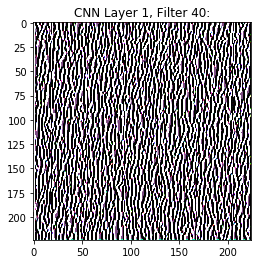

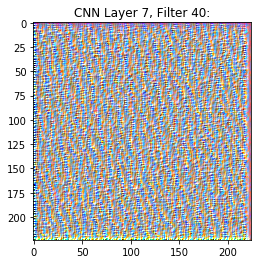

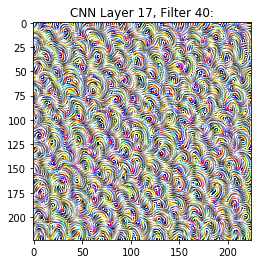

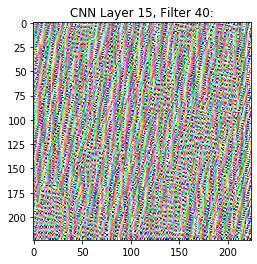

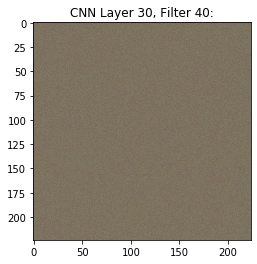

In [3]:
for cnn_layer in [1, 7, 17, 15, 30]:
    for filter_pos  in [40]:
        # Fully connected layer is not needed
        pretrained_model = models.vgg16(pretrained=True).features
        layer_vis = CNNLayerVisualization(pretrained_model, cnn_layer, filter_pos)

        # Layer visualization with pytorch hooks
        created_image = layer_vis.visualise()
        plt.figure()
        plt.title('CNN Layer {}, Filter {}:'.format(cnn_layer, filter_pos))
        plt.imshow(created_image)
